In [66]:
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

import statsmodels.api as sm
# from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from math import ceil, floor

import re

import time

import random

In [67]:
top_stats = pd.read_csv('Top_stats.csv')
top_stats.fillna(0, inplace=True)
print(top_stats.shape)
top_stats.head()

(2505, 73)


,id,ViewCount_2022-04-13,LikeCount_2022-04-13,FavoriteCount_2022-04-13,CommentCount_2022-04-13,viewCount_2022-04-14,likeCount_2022-04-14,favoriteCount2022-04-14,commentCount2022-04-14,viewCount_2022-04-15,...,favoriteCount2022-04-28,commentCount2022-04-28,viewCount_2022-04-29,likeCount_2022-04-29,favoriteCount2022-04-29,commentCount2022-04-29,viewCount_2022-04-30,likeCount_2022-04-30,favoriteCount2022-04-30,commentCount2022-04-30
0,yQEondeGvKo,6615947,476965.0,0,27539.0,2210903.0,552034.0,0.0,30541.0,2947627.0,...,0.0,42538.0,113571.0,861142.0,0.0,42695.0,88698.0,863270.0,0.0,42834.0
1,9jHioc3nNpM,1050155,91069.0,0,1881.0,210388.0,100802.0,0.0,2005.0,215201.0,...,0.0,2571.0,15103.0,134820.0,0.0,2577.0,12336.0,135395.0,0.0,2580.0
2,YyrYXMjdy0s,373592,57981.0,0,1397.0,74973.0,64306.0,0.0,1513.0,120570.0,...,0.0,1881.0,778.0,89630.0,0.0,1881.0,627.0,89669.0,0.0,1881.0
3,zR5DoUUovc0,5337765,178302.0,0,12330.0,980031.0,194504.0,0.0,13625.0,710262.0,...,0.0,14635.0,33061.0,217686.0,0.0,14654.0,20302.0,217854.0,0.0,14663.0
4,ldL1UFg5PKc,292441,22270.0,0,2906.0,64996.0,24653.0,0.0,3112.0,92511.0,...,0.0,4073.0,8294.0,37293.0,0.0,4086.0,7651.0,37558.0,0.0,4089.0


In [68]:
inds_view = []
inds_like = []
inds_count = []
for i, c in enumerate(top_stats.columns[::-1]):
    if c[1:4] == 'iew':
        inds_view.append(i)
        inds_like.append(i - 1)
        inds_count.append(i - 3)
        
for j in range(len(inds_like) - 1):
    top_stats[top_stats.columns[::-1][inds_like[j]]] -= top_stats[top_stats.columns[::-1][inds_like[j + 1]]]

for j in range(len(inds_count) - 1):
    top_stats[top_stats.columns[::-1][inds_count[j]]] -= top_stats[top_stats.columns[::-1][inds_count[j + 1]]]

In [69]:
top_stats

,id,ViewCount_2022-04-13,LikeCount_2022-04-13,FavoriteCount_2022-04-13,CommentCount_2022-04-13,viewCount_2022-04-14,likeCount_2022-04-14,favoriteCount2022-04-14,commentCount2022-04-14,viewCount_2022-04-15,...,favoriteCount2022-04-28,commentCount2022-04-28,viewCount_2022-04-29,likeCount_2022-04-29,favoriteCount2022-04-29,commentCount2022-04-29,viewCount_2022-04-30,likeCount_2022-04-30,favoriteCount2022-04-30,commentCount2022-04-30
0,yQEondeGvKo,6615947,476965.0,0,27539.0,2210903.0,75069.0,0.0,3002.0,2947627.0,...,0.0,135.0,113571.0,2707.0,0.0,157.0,88698.0,2128.0,0.0,139.0
1,9jHioc3nNpM,1050155,91069.0,0,1881.0,210388.0,9733.0,0.0,124.0,215201.0,...,0.0,5.0,15103.0,676.0,0.0,6.0,12336.0,575.0,0.0,3.0
2,YyrYXMjdy0s,373592,57981.0,0,1397.0,74973.0,6325.0,0.0,116.0,120570.0,...,0.0,0.0,778.0,40.0,0.0,0.0,627.0,39.0,0.0,0.0
3,zR5DoUUovc0,5337765,178302.0,0,12330.0,980031.0,16202.0,0.0,1295.0,710262.0,...,0.0,12.0,33061.0,335.0,0.0,19.0,20302.0,168.0,0.0,9.0
4,ldL1UFg5PKc,292441,22270.0,0,2906.0,64996.0,2383.0,0.0,206.0,92511.0,...,0.0,10.0,8294.0,292.0,0.0,13.0,7651.0,265.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,nrS-eRx-g3A,3497694,43070.0,0,1332.0,37807.0,206.0,0.0,6.0,66689.0,...,0.0,2.0,8823.0,45.0,0.0,0.0,8204.0,36.0,0.0,0.0
2501,EYFhiBPD1tE,1060394,20087.0,0,300.0,64442.0,467.0,0.0,3.0,117172.0,...,0.0,1.0,18190.0,168.0,0.0,1.0,16916.0,168.0,0.0,1.0
2502,8zSrfM3vECM,75784,4904.0,0,391.0,1285.0,46.0,0.0,2.0,2654.0,...,0.0,0.0,630.0,25.0,0.0,0.0,376.0,9.0,0.0,0.0
2503,arU-pVm3Kgw,61822,6839.0,0,213.0,11408.0,865.0,0.0,18.0,21502.0,...,0.0,1.0,1079.0,26.0,0.0,0.0,1096.0,27.0,0.0,1.0


In [70]:
neg_top = set()
for row in top_stats.iterrows():
    for c, v in row[1].items():
        if c[1:4] == 'iew' and v < 0:
            neg_top.add(row[0])
            top_stats.drop(row[0], inplace=True)
            break
len(neg_top)

358

In [71]:
cat_stats = pd.read_csv('Categories_stats.csv')
print(cat_stats.shape)
cat_stats.head()

(5928, 73)


,id,ViewCount_2022-04-13,LikeCount_2022-04-13,FavoriteCount_2022-04-13,CommentCount_2022-04-13,viewCount_2022-04-14,likeCount_2022-04-14,favoriteCount2022-04-14,commentCount2022-04-14,viewCount_2022-04-15,...,favoriteCount2022-04-28,commentCount2022-04-28,viewCount_2022-04-29,likeCount_2022-04-29,favoriteCount2022-04-29,commentCount2022-04-29,viewCount_2022-04-30,likeCount_2022-04-30,favoriteCount2022-04-30,commentCount2022-04-30
0,4kVKdzSUYqc,2561298,189410.0,0,491.0,251171.0,208011.0,0.0,538.0,364840.0,...,0.0,820.0,32978.0,309737.0,0.0,828.0,25311.0,311437.0,0.0,831.0
1,uKpwKofBvzY,23635337,874775.0,0,3270.0,-23311473.0,13433.0,0.0,765.0,34672.0,...,0.0,825.0,1744.0,15490.0,0.0,825.0,1208.0,15520.0,0.0,825.0
2,NoQI7F1XS7Q,277034,12332.0,0,714.0,467539.0,0.0,0.0,0.0,121970.0,...,0.0,0.0,2.0,0.0,0.0,0.0,415.0,1.0,0.0,0.0
3,L1QNg1vEAJw,678397,0.0,0,0.0,324521.0,30740.0,0.0,1826.0,8443.0,...,0.0,1851.0,624.0,31503.0,0.0,1851.0,308.0,31513.0,0.0,1853.0
4,in66Uz2OQYg,995249,30535.0,0,1821.0,1818045.0,71497.0,0.0,593.0,268049.0,...,0.0,658.0,2072.0,76804.0,0.0,659.0,2120.0,76824.0,0.0,659.0


In [72]:
for j in range(len(inds_like) - 1):
    cat_stats[cat_stats.columns[::-1][inds_like[j]]] -= cat_stats[cat_stats.columns[::-1][inds_like[j + 1]]]

for j in range(len(inds_count) - 1):
    cat_stats[cat_stats.columns[::-1][inds_count[j]]] -= cat_stats[cat_stats.columns[::-1][inds_count[j + 1]]]

In [73]:
neg_cat = set()
for row in cat_stats.iterrows():
    for c, v in row[1].items():
        if c[1:4] == 'iew' and v < 0:
            neg_cat.add(row[0])
            cat_stats.drop(row[0], inplace=True)
            break
            
len(neg_cat)

978

In [74]:
top = pd.read_csv('Top.csv')
top = top.loc[top_stats.index]
print(top.shape)
top.head()

(2147, 25)


,id,viewCount,likeCount,favoriteCount,commentCount,duration,dimension,definition,caption,licensedContent,...,description,thumbnails,channelTitle,tags,categoryId,liveBroadcastContent,defaultAudioLanguage,defaultLanguage,regionRestriction,date
0,yQEondeGvKo,6615947,476965.0,0,27539.0,197.0,2d,hd,True,True,...,It’s time. See you on the other side. Stranger...,{'default': {'url': 'https://i.ytimg.com/vi/yQ...,Stranger Things,"['caleb mclaughlin', 'charlie heaton', 'chief ...",Entertainment,none,en-US,NaN,NaN,2022-04-13
1,9jHioc3nNpM,1050155,91069.0,0,1881.0,1069.0,2d,hd,False,True,...,رابط العروض القوية في متجر هوواوي 💪 من هنا : h...,{'default': {'url': 'https://i.ytimg.com/vi/9j...,قناة سعود Saud Channel l,NaN,Entertainment,none,ar,NaN,NaN,2022-04-13
2,YyrYXMjdy0s,373592,57981.0,0,1397.0,637.0,2d,hd,False,True,...,كود الشوب (M55)\n\nقناة البث المباشر: https://...,{'default': {'url': 'https://i.ytimg.com/vi/Yy...,Yasser M55,"['فورتنايت', 'فورت نايت', 'جلد', 'دو عشوائي', ...",Gaming,none,ar,NaN,NaN,2022-04-13
3,zR5DoUUovc0,5337765,178302.0,0,12330.0,46.0,2d,hd,True,True,...,『ONE PIECE FILM RED』 2022年8月6日（土）公開！ \n物語のカギとな...,{'default': {'url': 'https://i.ytimg.com/vi/zR...,ONE PIECE公式YouTubeチャンネル,NaN,Film & Animation,none,ja,NaN,NaN,2022-04-13
4,ldL1UFg5PKc,292441,22270.0,0,2906.0,1102.0,2d,hd,False,True,...,رابط قناتي الثانيه اللي قلت عنها اشتركوا فيها ...,{'default': {'url': 'https://i.ytimg.com/vi/ld...,رواف | RAWAF,"['#رواف', '#روبلوكس', '#Roblox', '#adopt_me', ...",Gaming,none,ar,ar,NaN,2022-04-13


In [75]:
cat = pd.read_csv('Categories.csv')
cat = cat.loc[cat_stats.index]
print(cat.shape)
cat.head()

(4950, 25)


,id,viewCount,likeCount,favoriteCount,commentCount,duration,dimension,definition,caption,licensedContent,...,description,thumbnails,channelTitle,tags,categoryId,liveBroadcastContent,defaultAudioLanguage,defaultLanguage,regionRestriction,date
0,4kVKdzSUYqc,2561298,189410.0,0,491.0,43.0,2d,hd,False,False,...,Petrol വെള്ളത്തിൽ ഒഴിച്ചു 💥കത്തി 😵/Petrol Vs W...,{'default': {'url': 'https://i.ytimg.com/vi/4k...,TTM Voiced,"['Petrol Vs Water Experiment', 'Petrol Vs Wate...",Science & Technology,none,NaN,NaN,NaN,2022-04-13
2,NoQI7F1XS7Q,277034,12332.0,0,714.0,1834.0,2d,hd,True,True,...,സിങ്കപ്പൂർ യാത്ര അവസാനിപ്പിച്ച് വീട്ടിലേക്ക് മ...,{'default': {'url': 'https://i.ytimg.com/vi/No...,Tech Travel Eat by Sujith Bhakthan,"['tech travel eat', 'sujith bhakthan', 'malaya...",Travel & Events,none,ml,ml,NaN,2022-04-13
3,L1QNg1vEAJw,678397,0.0,0,0.0,60.0,2d,hd,False,False,...,اكتشف القوة والأمان والراحة والأداء مع سيارات ...,{'default': {'url': 'https://i.ytimg.com/vi/L1...,Volkswagen Middle East,"['طوارق', 'تيرامونت', 'تيغوان', 'فولكس واجن', ...",Autos & Vehicles,none,ar,NaN,NaN,2022-04-13
4,in66Uz2OQYg,995249,30535.0,0,1821.0,328.0,2d,hd,False,True,...,തൃശ്ശൂർ സ്വദേശിയായ സജീവനാണ് പൊലീസിനും സെെന്യത്...,{'default': {'url': 'https://i.ytimg.com/vi/in...,asianetnews,"['Malayalam news', 'Malayalam breaking news', ...",News & Politics,none,ml,en,NaN,2022-04-13
7,9TMgWpmQyAM,70996,2421.0,0,213.0,1261.0,2d,hd,False,True,...,Please Like & Subscribe Safari Channel: https:...,{'default': {'url': 'https://i.ytimg.com/vi/9T...,Safari,"['Safari Tv', 'Sancharam', 'Santhosh George Ku...",Travel & Events,none,ml,NaN,NaN,2022-04-13


In [305]:
df_stats = pd.concat([top_stats, cat_stats], ignore_index=True, axis=0).drop_duplicates('id')
df_info = pd.concat([top, cat], ignore_index=True, axis=0).drop_duplicates('id')
df = pd.concat([df_stats, df_info], axis=1)
df.fillna(0, inplace=True)
print(df.shape)
df.head()

(6322, 98)


,id,ViewCount_2022-04-13,LikeCount_2022-04-13,FavoriteCount_2022-04-13,CommentCount_2022-04-13,viewCount_2022-04-14,likeCount_2022-04-14,favoriteCount2022-04-14,commentCount2022-04-14,viewCount_2022-04-15,...,description,thumbnails,channelTitle,tags,categoryId,liveBroadcastContent,defaultAudioLanguage,defaultLanguage,regionRestriction,date
0,yQEondeGvKo,6615947,476965.0,0,27539.0,2210903.0,75069.0,0.0,3002.0,2947627.0,...,It’s time. See you on the other side. Stranger...,{'default': {'url': 'https://i.ytimg.com/vi/yQ...,Stranger Things,"['caleb mclaughlin', 'charlie heaton', 'chief ...",Entertainment,none,en-US,0,0,2022-04-13
1,9jHioc3nNpM,1050155,91069.0,0,1881.0,210388.0,9733.0,0.0,124.0,215201.0,...,رابط العروض القوية في متجر هوواوي 💪 من هنا : h...,{'default': {'url': 'https://i.ytimg.com/vi/9j...,قناة سعود Saud Channel l,0,Entertainment,none,ar,0,0,2022-04-13
2,YyrYXMjdy0s,373592,57981.0,0,1397.0,74973.0,6325.0,0.0,116.0,120570.0,...,كود الشوب (M55)\n\nقناة البث المباشر: https://...,{'default': {'url': 'https://i.ytimg.com/vi/Yy...,Yasser M55,"['فورتنايت', 'فورت نايت', 'جلد', 'دو عشوائي', ...",Gaming,none,ar,0,0,2022-04-13
3,zR5DoUUovc0,5337765,178302.0,0,12330.0,980031.0,16202.0,0.0,1295.0,710262.0,...,『ONE PIECE FILM RED』 2022年8月6日（土）公開！ \n物語のカギとな...,{'default': {'url': 'https://i.ytimg.com/vi/zR...,ONE PIECE公式YouTubeチャンネル,0,Film & Animation,none,ja,0,0,2022-04-13
4,ldL1UFg5PKc,292441,22270.0,0,2906.0,64996.0,2383.0,0.0,206.0,92511.0,...,رابط قناتي الثانيه اللي قلت عنها اشتركوا فيها ...,{'default': {'url': 'https://i.ytimg.com/vi/ld...,رواف | RAWAF,"['#رواف', '#روبلوكس', '#Roblox', '#adopt_me', ...",Gaming,none,ar,ar,0,2022-04-13


In [391]:
X = df[[*top_stats.columns[::-1][inds_view][::-1].to_list(), *top_stats.columns[::-1][inds_like][::-1].to_list(),
        *top_stats.columns[::-1][inds_count][::-1].to_list(), 
        'duration', 'definition', 'publishedAt', 'title', 'description', 'categoryId']]
X.index = df.iloc[:,0]
X.loc[:, 'Month'] = pd.to_datetime(X.publishedAt).dt.month.values
X.loc[:, 'Day'] = pd.to_datetime(X.publishedAt).dt.day.values
X.loc[:, 'Hour'] = pd.to_datetime(X.publishedAt).dt.hour.values
X.loc[:, 'Weekday'] = pd.to_datetime(X.publishedAt).dt.weekday.values
X.loc[(X['title'].str.upper() == X['title']), 'caps'] = 'Used'
X.loc[(X['title'].str.upper() != X['title']), 'caps'] = 'Not used'
X.loc[(X['description'].str.find('http') != -1.0) &
        ~(X['description'].str.find('http').isna()), 'link'] = 'Used'
X.loc[(X['description'].str.find('http') == -1.0) |
        (X['description'].str.find('http').isna()), 'link'] = 'Not used'


pred_val = 12 + 14 # last is 30, first is 13
target = f'viewCount_2022-04-{pred_val}' 
y = X[target]

drop_cols = []
for column in X.columns:
    if column[-2:].isdigit() and int(column[-2:]) >= pred_val:
        drop_cols.append(column)
          
X.drop(columns=[*drop_cols], inplace=True)
X.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [392]:
categorical = ['categoryId', 'Month', 'Weekday', 'Hour', 'definition', 'link', 'caps']

numeric_features = X.columns.drop([*categorical, 'title', 'description', 'publishedAt', 'Day'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

In [393]:
ans = pd.DataFrame(index=['DecisionTree', 'Ridge', 'Lasso', 'GradientBoosting', 
                          'Bagging', 'CatBoost', 'HuberRegressor', 'TheilSenRegressor'], 
                   columns=['MSE', 'R2', 'Time'])

In [394]:
def get_models(X_valid, y_valid):
    models = []
    max_depth = [3, 5, 7]
    max_features = [int(np.sqrt(X_train.shape[1])), X_train.shape[1] // 2, X_train.shape[1] - 1]
    alpha = np.logspace(-3, 0, 8, dtype='float')
    n_estimators = [25, 50, 100]

    print('Searching DecisionTreeRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', DecisionTreeRegressor(random_state=21))]), 
                            [{"regression__max_depth": max_depth, "regression__max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', DecisionTreeRegressor(random_state=21, 
                                                                 max_depth=searcher.best_params_["regression__max_depth"], 
                                                                 max_features=searcher.best_params_["regression__max_features"]))]))
    print('Finished!\n')

    print('Searching Ridge...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Ridge(random_state=21, solver='sag', max_iter=1000000))]), 
                            [{"regression__alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Ridge(random_state=21, solver='sag', max_iter=1000000, alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')

    print('Searching Lasso...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Lasso(random_state=21, max_iter=1000000))]), 
                            [{"regression__alpha" : np.logspace(-1, 0, 8, dtype='float')}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Lasso(random_state=21, max_iter=10000000, 
                                                 alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')

    print('Searching GradientBoostingRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state=21))]), 
                            [{"regression__n_estimators": n_estimators, "regression__max_depth": max_depth, 
                              "regression__alpha": np.logspace(-4, -0.01, 8, dtype='float')}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', GradientBoostingRegressor(warm_start=False, 
                                                                     alpha=searcher.best_params_["regression__alpha"], 
                                                                     max_depth=searcher.best_params_["regression__max_depth"], 
                                                                     n_estimators=searcher.best_params_["regression__n_estimators"],
                                                                     max_features='sqrt', random_state=21))]))
    print('Finished!\n')

    print('Searching BaggingRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', BaggingRegressor(random_state=21))]), 
                            [{"regression__n_estimators": n_estimators, "regression__max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', BaggingRegressor(random_state=21, 
                                                            n_estimators=searcher.best_params_["regression__n_estimators"], 
                                                            max_features=searcher.best_params_["regression__max_features"]))]))
    print('Finished!\n')

    print('Searching CatBoostRegressor...')
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', CatBoostRegressor(loss_function='RMSE', random_seed=21, logging_level='Silent'))]))
    print('Finished!\n')

    print('Searching HuberRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', HuberRegressor(max_iter=100000))]), 
                            [{"regression__alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', HuberRegressor(max_iter=100000, alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')
    
    print('Searching TheilSenRegressor...')
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', TheilSenRegressor(random_state=21))]))
    print('Finished!\n')
    
    return models

In [395]:
def testing(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):

    start = time.time()
    model.fit(X_train[[*numeric_features, *categorical]], y_train)
    fin = time.time() - start

    test = y_test.copy()
    y_pred = model.predict(X_test[[*numeric_features, *categorical]])

    MSE = mean_squared_error(y_pred, test)
    R2 = r2_score(test, y_pred)

    return MSE, R2, fin, y_pred, test

In [ ]:
batch = floor(X.shape[0] / 4)
print('Batch size:', batch)

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))

for i in range(1, 5):
    print(f'\nBatch {i}')
    
    X_test = X[batch * (i - 1) : batch * i]
    y_test = y[X_test.index]
    X_valid = X.loc[np.random.choice(X.drop(index=X_test.index.tolist()).index, 
                                             batch, replace=False)]
    y_valid = y[X_valid.index]
    X_train = X.drop(index=[*X_test.index.to_list(), *X_valid.index.to_list()])
    y_train = y[X_train.index]
    
    models_set = get_models(X_valid, y_valid)
    
    for j, model in enumerate(models_set):
        curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
        try:
            data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
            data['R2'][ans.index.to_list()[j]].append(curr_R2)
            data['Time'][ans.index.to_list()[j]].append(curr_fin)
            data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
            data['Act'][ans.index.to_list()[j]].extend(curr_test)
        except KeyError:
            data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
            data['R2'][ans.index.to_list()[j]] = [curr_R2]
            data['Time'][ans.index.to_list()[j]] = [curr_fin]
            data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
            data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

### Result in prediction the 11th day

In [361]:
data_11 = data.copy()

In [360]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 116939.89957009733 
	R2 0.6328591556804044 
	Time 0.3767664432525635
Ridge 
	RMSE 198310.52829465386 
	R2 -0.05584170484412487 
	Time 6.083375453948975
Lasso 
	RMSE 376384.10393543914 
	R2 -2.8033808537276794 
	Time 6.321014404296875
GradientBoosting 
	RMSE 283036.260088288 
	R2 -1.1507573877713964 
	Time 2.8920063972473145
Bagging 
	RMSE 77058.25591724635 
	R2 0.8405789666580414 
	Time 23.58285880088806
CatBoost 
	RMSE 89908.11118785152 
	R2 0.7829773724580686 
	Time 42.60174512863159
HuberRegressor 
	RMSE 167498.62427931314 
	R2 0.24676627266463624 
	Time 3.084083080291748
TheilSenRegressor 
	RMSE 2556335.021090779 
	R2 -174.44573243968506 
	Time 148.39185571670532


In [362]:
best_preds = [data['Pred']['Bagging'], data['Pred']['CatBoost'], 
              data['Pred']['DecisionTree']]
i = 0
while i < 3:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('RMSE', mean_squared_error(curr_pred, data['Act'][ans.index.to_list()[j]], squared=False))
    print('R2', r2_score(data['Act'][ans.index.to_list()[j]], curr_pred))
    print()
    i += 1

0
RMSE 77058.25591724635
R2 0.8405789666580414

1
RMSE 81330.6347961608
R2 0.8224111915237998

2
RMSE 84959.15678781396
R2 0.8062116539361761



### Result in prediction the 8th day

In [352]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 1989931.1755436165 
	R2 -2.1009454317138068 
	Time 0.2575643062591553
Ridge 
	RMSE 1919023.3133263392 
	R2 -1.8838888206232878 
	Time 6.541059732437134
Lasso 
	RMSE 4137649.162517331 
	R2 -12.406806420579269 
	Time 25.407878637313843
GradientBoosting 
	RMSE 3530711.32621534 
	R2 -8.762081596106745 
	Time 2.375314474105835
Bagging 
	RMSE 1144345.038746827 
	R2 -0.025491332538157385 
	Time 7.5946204662323
CatBoost 
	RMSE 1312311.8214333637 
	R2 -0.3486277568971581 
	Time 37.20140504837036
HuberRegressor 
	RMSE 1123475.7015579874 
	R2 0.011571225496603277 
	Time 7.129153490066528
TheilSenRegressor 
	RMSE 1131009.5758039136 
	R2 -0.0017297588446676393 
	Time 108.08472657203674


### Result in prediction the 18th day

In [326]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 42232.23223558545 
	R2 0.9178712492020988 
	Time 0.5079212188720703
Ridge 
	RMSE 189491.11339878498 
	R2 -0.653426286822385 
	Time 3.5759875774383545
Lasso 
	RMSE 278378.38155064336 
	R2 -2.5684379871688483 
	Time 4.522027015686035
GradientBoosting 
	RMSE 271150.16151290096 
	R2 -2.3855316459241336 
	Time 4.243422269821167
Bagging 
	RMSE 34727.603404472386 
	R2 0.9444662796436735 
	Time 35.23814606666565
CatBoost 
	RMSE 46804.43492204613 
	R2 0.8991255556845187 
	Time 56.892621755599976
HuberRegressor 
	RMSE 277417.37303620676 
	R2 -2.5438428299312004 
	Time 13.436310052871704
TheilSenRegressor 
	RMSE 331200.39186400606 
	R2 -4.051133264113535 
	Time 783.0295917987823


In [327]:
best_preds = [data['Pred']['Bagging'], data['Pred']['DecisionTree'], 
              data['Pred']['CatBoost']]
i = 0
while i < 3:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('RMSE', mean_squared_error(curr_pred, data['Act'][ans.index.to_list()[j]], squared=False))
    print('R2', r2_score(data['Act'][ans.index.to_list()[j]], curr_pred))
    print()
    i += 1

0
RMSE 34727.603404472386
R2 0.9444662796436735

1
RMSE 35383.96926076327
R2 0.9423472216970911

2
RMSE 36495.41860587672
R2 0.9386684639728708



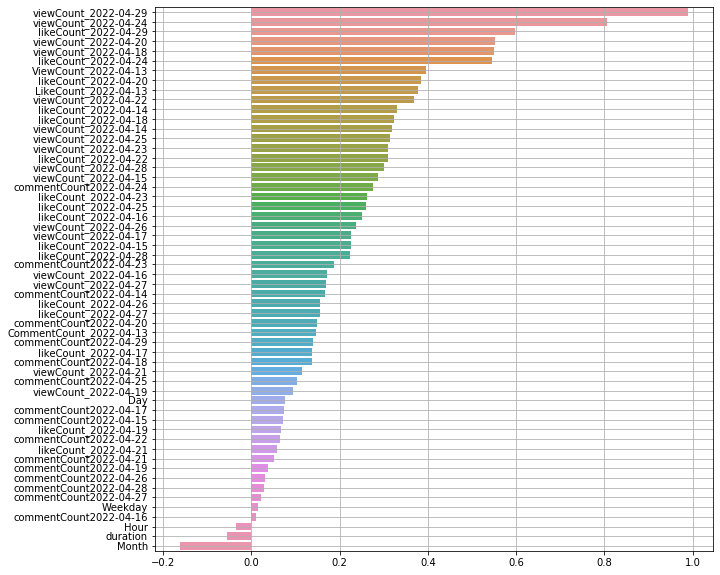

In [328]:
corr = X.corrwith(y).sort_values(ascending=False)
plot_views = sns.barplot(y=corr.index, x=corr)
plot_views.figure.set_size_inches(10, 10)
plt.grid()